# Celebrity Recognition using Amazon Rekognition


This notebook provides a walkthrough of [celebrity recognition API](https://docs.aws.amazon.com/rekognition/latest/dg/celebrities.html) in Amazon Rekognition. You can quickly identify well known people in your video and image libraries to catalog footage and photos for marketing, advertising, and media industry use cases.

* https://docs.aws.amazon.com/rekognition/latest/dg/celebrities.html
* https://docs.aws.amazon.com/rekognition/latest/dg/API_RecognizeCelebrities.html
* https://docs.aws.amazon.com/rekognition/latest/dg/API_StartCelebrityRecognition.html
* https://docs.aws.amazon.com/rekognition/latest/dg/API_GetCelebrityRecognition.html

# Setup

In [1]:
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os

In [2]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

In [3]:
rekognition = boto3.client("rekognition")
s3 = boto3.client("s3")

/home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [4]:
!mkdir -p ./tmp
temp_folder = "tmp/"

# Recognize Celebrities in Images

In [5]:
imageName = "content-moderation/media/GrandTourjc.png"

In [6]:
display(IImage(url=s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": imageName})))

# Call Amazon Rekognition to recognize celebrities in the image
https://docs.aws.amazon.com/rekognition/latest/dg/API_RecognizeCelebrities.html

In [7]:
recognizeCelebritiesResponse = rekognition.recognize_celebrities(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name": imageName,
        }
    }
)

# Review JSON response returned by Rekognition Celebrity Recognition API
In the JSON response below, you will see CelebrityFaces which contains information about recognized celebrities.

For each recognized celebrity, you will see information like Name, Id, Urls and additional information about their facial attributes.

In [8]:
display(recognizeCelebritiesResponse)

{'CelebrityFaces': [{'Urls': ['www.wikidata.org/wiki/Q216160',
    'www.imdb.com/name/nm0165087'],
   'Name': 'Jeremy Clarkson',
   'Id': '2mW0ey5n',
   'Face': {'BoundingBox': {'Width': 0.17245951294898987,
     'Height': 0.5064846277236938,
     'Left': 0.20956459641456604,
     'Top': 0.1436367630958557},
    'Confidence': 99.9980239868164,
    'Landmarks': [{'Type': 'nose',
      'X': 0.37251022458076477,
      'Y': 0.43928447365760803},
     {'Type': 'eyeLeft', 'X': 0.3125169277191162, 'Y': 0.33740484714508057},
     {'Type': 'mouthLeft', 'X': 0.30566859245300293, 'Y': 0.5114881992340088},
     {'Type': 'mouthRight', 'X': 0.34567299485206604, 'Y': 0.529137909412384},
     {'Type': 'eyeRight', 'X': 0.3611130118370056, 'Y': 0.36034104228019714}],
    'Pose': {'Roll': 9.265666007995605,
     'Yaw': 47.319950103759766,
     'Pitch': 2.151289701461792},
    'Quality': {'Brightness': 65.40837860107422,
     'Sharpness': 83.14741516113281},
    'Emotions': [{'Type': 'CALM', 'Confidence':

# Show Image with Bounding Boxes Around Recognized Celebrities

In [9]:
def drawBoundingBoxes(sourceImage, boxes):
    # blue, green, red, grey
    colors = ((255, 255, 255), (255, 255, 255), (76, 182, 252), (52, 194, 123))

    # Download image locally
    imageLocation = temp_folder + os.path.basename(sourceImage)
    s3.download_file(bucket, sourceImage, imageLocation)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line = 3
    for box in boxes:
        x1 = int(box[1]["Left"] * width)
        y1 = int(box[1]["Top"] * height)
        x2 = int(box[1]["Left"] * width + box[1]["Width"] * width)
        y2 = int(box[1]["Top"] * height + box[1]["Height"] * height)

        draw.text((x1, y1), box[0], colors[col])
        for l in range(line):
            draw.rectangle((x1 - l, y1 - l, x2 + l, y2 + l), outline=colors[col])
        col = (col + 1) % maxcol

    imageFormat = "PNG"
    ext = sourceImage.lower()
    if ext.endswith("jpg") or ext.endswith("jpeg"):
        imageFormat = "JPEG"

    bbImage.save(imageLocation, format=imageFormat)

    display(bbImage)

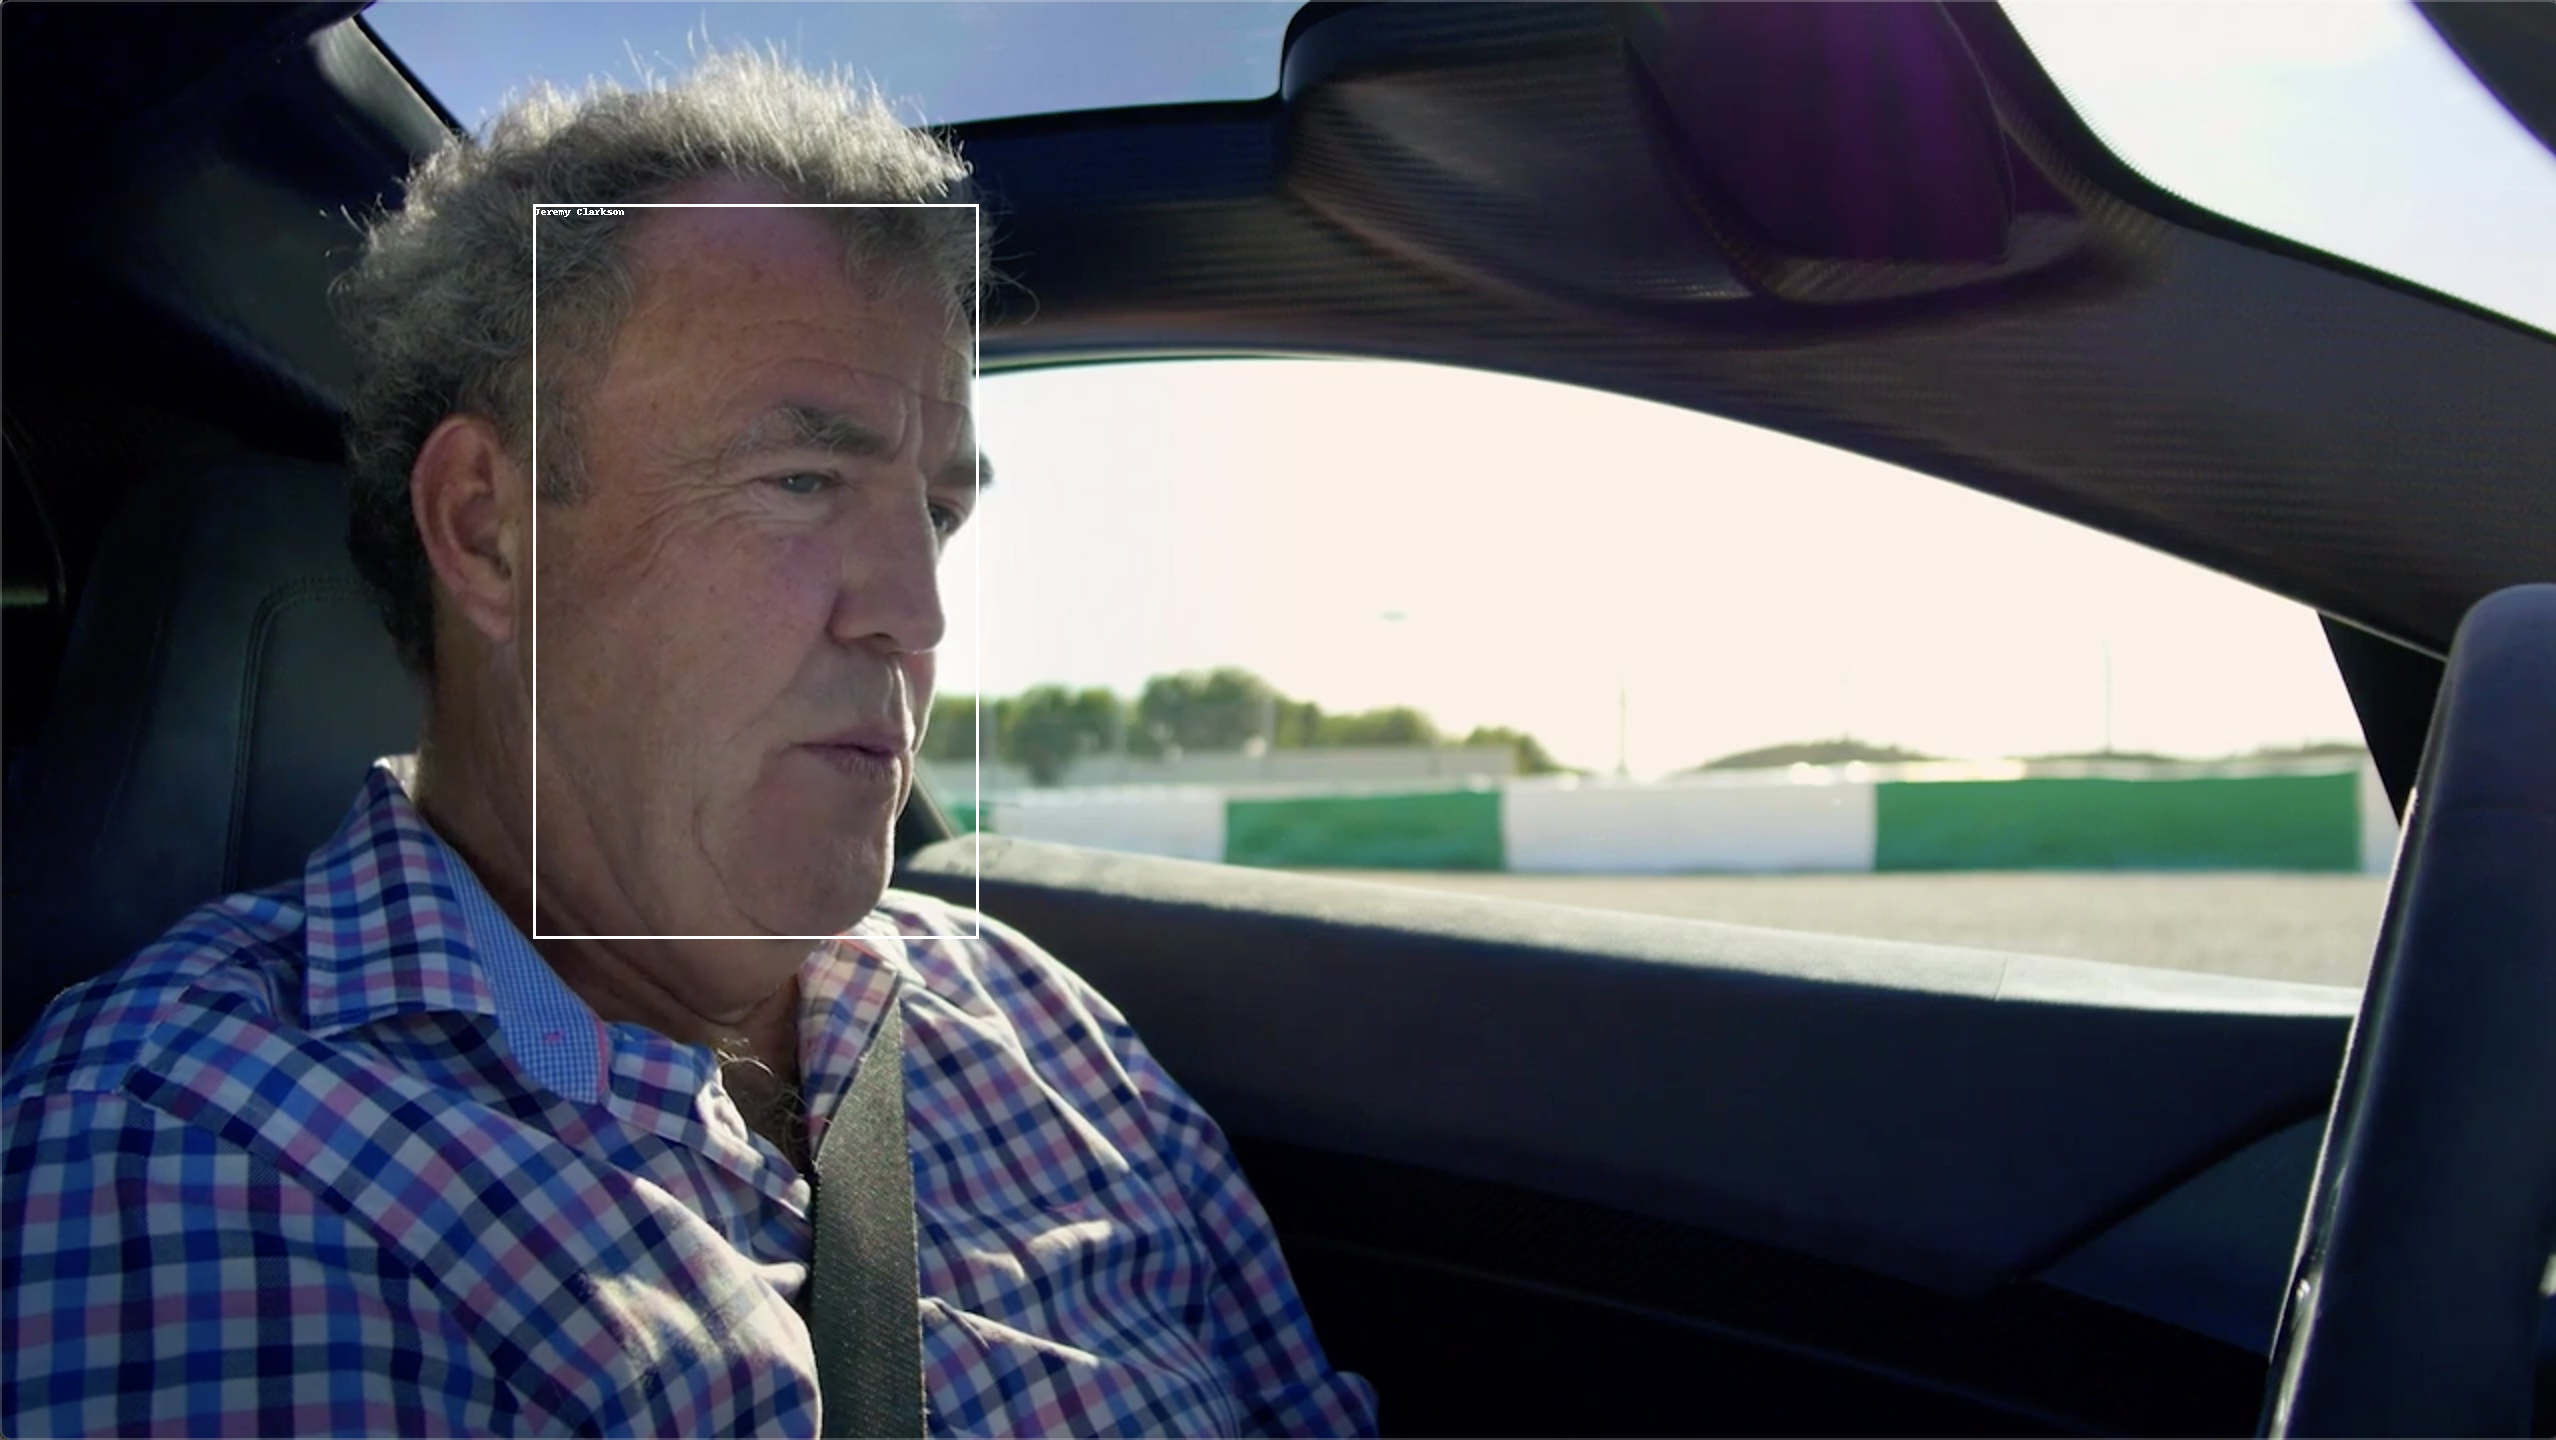

In [10]:
boxes = []
celebrities = recognizeCelebritiesResponse["CelebrityFaces"]
for celebrity in celebrities:
    boxes.append((celebrity["Name"], celebrity["Face"]["BoundingBox"]))

drawBoundingBoxes(imageName, boxes)

# Recognize Celebrities in Videos
 Celebrity recognition in video is an async operation. 
 https://docs.aws.amazon.com/rekognition/latest/dg/API_StartCelebrityRecognition.html
 - We first start celebrity recognition job which returns a Job Id.
 - We can then call `get_celebrity_recognition` to get the job status and after job is complete, we can get celebrity metadata.
 - In production use cases, you would usually use StepFucntion or SNS topic to get notified when job is complete.

In [11]:
videoName = "content-moderation/media/GrandTour720.mp4"
strDetail = "Celebrites detected in video<br>=======================================<br>"
strOverall = "Celebrities in the overall video:<br>=======================================<br>"

In [12]:
s3FilePrefix = "https://s3.amazonaws.com"
if not region == "us-east-1":
    s3FilePrefix = "https://s3-{}.amazonaws.com".format(region)

s3VideoUrl = "{0}/{1}/{2}".format(s3FilePrefix, bucket, videoName)

videoTag = "<video controls='controls' autoplay width='640' height='360' name='Video' src='{0}'></video>".format(
    s3VideoUrl
)

videoui = "<table><tr><td style='vertical-align: top'>{}</td></tr><tr><td>{}</td></tr></table>".format(
    videoTag, strDetail
)

display(HTML(videoui))

""
Celebrites detected in video=======================================


# Call Rekognition to Start a Job for Celebrity Rekognition

In [13]:
startCelebrityRekognition = rekognition.start_celebrity_recognition(
    Video={
        "S3Object": {
            "Bucket": bucket,
            "Name": videoName,
        }
    },
)

celebrityJobId = startCelebrityRekognition["JobId"]
display("Job Id: {0}".format(celebrityJobId))

'Job Id: 86fab6f99f35bcdf7857dc393a4e25f1a27acce91ca0df9fdf86c35ac6ca6143'

# Wait for Celebrity Rekognition Job to Complete
* In production use cases, you would usually use StepFucntion or SNS topic to get notified when job is complete.


In [14]:
%%time

getCelebrityRecognition = rekognition.get_celebrity_recognition(JobId=celebrityJobId, SortBy="TIMESTAMP")

while getCelebrityRecognition["JobStatus"] == "IN_PROGRESS":
    time.sleep(5)
    print(".", end="")

    getCelebrityRecognition = rekognition.get_celebrity_recognition(JobId=celebrityJobId, SortBy="TIMESTAMP")

display(getCelebrityRecognition["JobStatus"])

.......

'SUCCEEDED'

CPU times: user 33.9 ms, sys: 4.15 ms, total: 38.1 ms
Wall time: 35.2 s


# Review JSON response returned by Rekognition Celebrity Recognition API
In the JSON response below, you will see list Celebrities which contains information about recognized celebrities.

For each recognized celebrity, you will see information like Timestamp, Name, Id, Urls
 and additional information about their facial attributes.

In [15]:
display(getCelebrityRecognition)

{'JobStatus': 'SUCCEEDED',
 'VideoMetadata': {'Codec': 'h264',
  'DurationMillis': 15015,
  'Format': 'QuickTime / MOV',
  'FrameRate': 23.976024627685547,
  'FrameHeight': 720,
  'FrameWidth': 1280,
  'ColorRange': 'LIMITED'},
 'Celebrities': [{'Timestamp': 2460,
   'Celebrity': {'Urls': ['www.wikidata.org/wiki/Q216160',
     'www.imdb.com/name/nm0165087'],
    'Name': 'Jeremy Clarkson',
    'Id': '2mW0ey5n',
    'Confidence': 99.83981323242188,
    'Face': {'BoundingBox': {'Width': 0.17029087245464325,
      'Height': 0.5028613805770874,
      'Left': 0.21125762164592743,
      'Top': 0.1456305980682373},
     'Landmarks': [{'Type': 'eyeLeft',
       'X': 0.31368258595466614,
       'Y': 0.336062490940094},
      {'Type': 'eyeRight', 'X': 0.36271932721138, 'Y': 0.36189624667167664},
      {'Type': 'mouthLeft', 'X': 0.3011455237865448, 'Y': 0.5094919204711914},
      {'Type': 'mouthRight', 'X': 0.3415478467941284, 'Y': 0.529556155204773},
      {'Type': 'nose', 'X': 0.3696622252464294

# Display Names of Recognized Celebrities in the Video
Display timestamps and celebrites detected at that time.


In [16]:
theCelebs = {}

# Celebrities detected in each frame
for celebrity in getCelebrityRecognition["Celebrities"]:
    if "Celebrity" in celebrity:
        cconfidence = celebrity["Celebrity"]["Confidence"]
        if cconfidence > 95:
            ts = celebrity["Timestamp"]
            cname = celebrity["Celebrity"]["Name"]
            strDetail = strDetail + "At {} ms: {} (Confidence: {})<br>".format(ts, cname, round(cconfidence, 2))
            if not cname in theCelebs:
                theCelebs[cname] = cname


# Unique faces detected in video
for theCeleb in theCelebs:
    strOverall = strOverall + "Name: {}<br>".format(theCeleb)

# Display results
display(HTML(strOverall))

# Detect Non-Celebrities
Now let us try an image with non-celebrities in the image.


In [17]:
customCelebrityImageName = "content-moderation/media/chris-antje.png"

In [18]:
display(
    IImage(url=s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": customCelebrityImageName}))
)

In [19]:
# Call Amazon Rekognition to recognize celebrities in the image

customCelebrityResponse = rekognition.recognize_celebrities(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name": customCelebrityImageName,
        }
    }
)

# Display Rekognition Response
You will see Rekognition return an empty list for CelebrityFaces and 

UnrecognizedFaces list with unrecognized faces that were detected in the image.

In the next module you will learn how to get custom-celebrity faces recognized.


In [20]:
display(customCelebrityResponse)

{'CelebrityFaces': [],
 'UnrecognizedFaces': [{'BoundingBox': {'Width': 0.20627911388874054,
    'Height': 0.3899897038936615,
    'Left': 0.25654977560043335,
    'Top': 0.4376027286052704},
   'Confidence': 99.9995346069336,
   'Landmarks': [{'Type': 'nose',
     'X': 0.3577640652656555,
     'Y': 0.6789306402206421},
    {'Type': 'eyeLeft', 'X': 0.3156965374946594, 'Y': 0.5915206074714661},
    {'Type': 'mouthLeft', 'X': 0.31642886996269226, 'Y': 0.7188389897346497},
    {'Type': 'mouthRight', 'X': 0.3966156244277954, 'Y': 0.7275944948196411},
    {'Type': 'eyeRight', 'X': 0.41131192445755005, 'Y': 0.601748526096344}],
   'Pose': {'Roll': 3.4131057262420654,
    'Yaw': -0.7230275273323059,
    'Pitch': -5.356732368469238},
   'Quality': {'Brightness': 59.37363052368164,
    'Sharpness': 60.49041748046875},
   'Emotions': [{'Type': 'HAPPY', 'Confidence': 93.38072204589844},
    {'Type': 'SURPRISED', 'Confidence': 2.578389883041382},
    {'Type': 'CONFUSED', 'Confidence': 1.3079657554

# Show Image and Bounded Boxes around Detected Faces

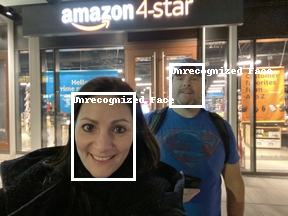

In [21]:
cboxes = []
faces = customCelebrityResponse["UnrecognizedFaces"]
for face in faces:
    cboxes.append(("Unrecognized Face", face["BoundingBox"]))

drawBoundingBoxes(customCelebrityImageName, cboxes)

# Congratulations!
You have successfully used Amazon Rekognition to identify celebrities in images an videos. 

# References
- https://docs.aws.amazon.com/rekognition/latest/dg/celebrities.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_RecognizeCelebrities.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_StartCelebrityRecognition.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_GetCelebrityRecognition.html

# Release Resources

In [22]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [23]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>